In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import sys


if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    

os.chdir(r'C:\Users\User\GitHub\WebET_Analysis')
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [2]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read Data

In [3]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

print(pd.DataFrame([[len(data_et)], [len(data_trial)], [len(data_subject)]], 
                   columns=['length'],
                   index=['data_et', 'data_trial', 'data_subject'])
     )

              length
data_et       618566
data_trial     30362
data_subject      88


# Create datasets

## data_trial_choice

In [4]:
data_trial_choice = data_trial.loc[
    data_trial['trial_type']=='eyetracking-choice', 
    [
        'run_id', 'chinFirst', 
        'task_nr', 
        'trial_index', 'trial_type', 'withinTaskIndex', 
        'choiceTask_amountLeftFirst', 
        'option_topLeft', 'option_bottomLeft',
        'option_topRight', 'option_bottomRight',
        'key_press', 'trial_duration_exact',
        'window_width', 'window_height',
        'fps'
    ]
]

## data_et_choice

In [5]:
def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'withinTaskIndex')

data_et_choice = data_et \
    .loc[data_et['trial_type']=='eyetracking-choice', :] \
    .drop(columns=['trial_type'])
data_et_choice

,x,y,t,t_task,run_id,trial_index,withinTaskIndex
607,0.627605,0.429164,509546.610,0.000,1.0,145.0,1.0
608,0.604833,0.425830,510013.380,466.770,1.0,145.0,1.0
609,0.622740,0.387974,510486.345,939.735,1.0,145.0,1.0
610,0.592737,0.415015,510958.065,1411.455,1.0,145.0,1.0
611,0.498632,0.300594,511430.640,1884.030,1.0,145.0,1.0
...,...,...,...,...,...,...,...
618561,0.288021,0.317593,1438291.000,1212.000,2009.0,507.0,80.0
618562,0.288021,0.317593,1438365.000,1286.000,2009.0,507.0,80.0
618563,0.288021,0.317593,1438437.000,1358.000,2009.0,507.0,80.0
618564,0.288021,0.317593,1438512.000,1433.000,2009.0,507.0,80.0


# Screening

## Not enough trials

In [6]:
def merge_max_var_by_index(data, data_subject, varName, newName):
    grouped = data \
        .groupby(['run_id'])[varName].max() \
        .reset_index() \
        .rename(columns={varName: newName})
    if newName in data_subject.columns:
        data_subject = data_subject.drop(columns=[newName])
    data_subject = data_subject.merge(
        grouped, 
        on='run_id',
        how='left'
    )
    return data_subject

data_subject = merge_max_var_by_index(
    data_trial_choice, 
    data_subject, 
    'withinTaskIndex', 
    'max_choiceIndex'
)

data_subject = merge_max_var_by_index(
    data_trial, 
    data_subject, 
    'trial_index', 
    'max_trial_index'
)
data_subject.loc[
    data_subject['max_choiceIndex']!=80,
    ['run_id', 'max_trial_index', 'max_choiceIndex']
].sort_values(by='run_id')

,run_id,max_trial_index,max_choiceIndex
13,14,NaN,NaN
30,49,NaN,NaN
32,54,NaN,NaN
37,61,271.0,42.0
43,72,NaN,NaN
48,83,NaN,NaN
50,88,NaN,NaN
60,99,NaN,NaN
2,106,NaN,NaN
3,108,NaN,NaN


In [7]:
subjects_not_enough_trials = data_subject.loc[
    pd.isna(data_subject['max_choiceIndex']) |
    (data_subject['max_choiceIndex']<40),
    'run_id'
]
subjects_not_enough_trials

2      106
3      108
6      124
7      125
13      14
30      49
32      54
43      72
48      83
50      88
60      99
62    1001
64    1014
65    1015
66    1016
67    1017
68    1019
69    1002
70    1020
73    1007
75    1009
76    1022
77    1024
78    2011
81    2015
82    2016
83    2017
84    2002
85    2020
Name: run_id, dtype: int64

## Did not keep head still

In [8]:
data_subject.loc[
    data_subject['keptHead']==0, 
    ['run_id', 'prolificID', 'keptHead']
]

,run_id,prolificID,keptHead
84,2002,Tim2,0.0
86,2008,Studie1970,0.0


In [9]:
subjects_not_kept_head = data_subject.loc[
    data_subject['keptHead']==0, 'run_id']

## Not approved on Prolific

In [10]:
data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    :
]

,run_id,birthyear,browliner,browser,browser_version,degree,device,ethnic,eyeliner,eyeshadow,...,Country of Birth,Current Country of Residence,Employment Status,First Language,Nationality,Sex,Student Status,fps,max_choiceIndex,max_trial_index
7,125,NaN,NaN,Chrome,87.0.4280.88,NaN,Macintosh,NaN,NaN,NaN,...,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,CONSENT REVOKED,NaN,NaN,15.0


In [11]:
subjects_notApproved = data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    'run_id'
]
subjects_notApproved

7    125
Name: run_id, dtype: int64

## Trials too long

In [12]:
data_trial_choice.loc[data_trial_choice['trial_duration_exact']>10000, :]

,run_id,chinFirst,task_nr,trial_index,trial_type,withinTaskIndex,choiceTask_amountLeftFirst,option_topLeft,option_bottomLeft,option_topRight,option_bottomRight,key_press,trial_duration_exact,window_width,window_height,fps
787,103,0.0,3.0,270.0,eyetracking-choice,1.0,0.0,180 days,Today,$4.5,$3,40.0,12336.0,1536.0,864.0,21.400778
6013,25,0.0,3.0,303.0,eyetracking-choice,12.0,1.0,$4.5,$5,Today,7 days,38.0,10705.0,1536.0,864.0,14.666044
9192,38,1.0,2.0,374.0,eyetracking-choice,77.0,1.0,Today,Tomorrow,$3,$4,40.0,12120.0,1920.0,1080.0,NaN
9728,4,0.0,3.0,391.0,eyetracking-choice,41.0,1.0,90 days,Today,$4,$2.5,40.0,10375.0,1920.0,1080.0,10.698795
9740,4,0.0,3.0,403.0,eyetracking-choice,45.0,1.0,Today,30 days,$2.5,$5,40.0,18030.0,1920.0,1007.0,10.704382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29558,2008,1.0,2.0,231.0,eyetracking-choice,30.0,1.0,$5,$1.5,30 days,Today,40.0,26293.0,1920.0,1080.0,12.893165
29561,2008,1.0,2.0,234.0,eyetracking-choice,31.0,1.0,$4.5,$2,180 days,Today,40.0,14377.0,1920.0,1080.0,13.006886
29592,2008,1.0,2.0,265.0,eyetracking-choice,41.0,1.0,30 days,Today,$4.5,$4,40.0,12630.0,1920.0,1080.0,12.905780
29658,2008,1.0,2.0,331.0,eyetracking-choice,63.0,1.0,Today,90 days,$2.5,$5,38.0,12765.0,1920.0,1080.0,12.769291


## Not enough fps

In [13]:
grouped = data_et_choice \
    .groupby(['run_id', 'trial_index'])['x'].count() \
    .reset_index() \
    .rename(columns={'x': 'x_count'})
if 'x_count' in data_trial_choice.columns:
    data_trial_choice = data_trial_choice.drop(columns=['x_count'])
data_trial_choice = data_trial_choice \
    .merge(grouped, on=['run_id', 'trial_index'], how='left')
print(data_trial_choice.columns)
data_trial_choice['fps_choice']= \
    1000 * data_trial_choice['x_count'] / \
    data_trial_choice['trial_duration_exact']
data_trial_choice['fps_choice'].describe()

Index(['run_id', 'chinFirst', 'task_nr', 'trial_index', 'trial_type',
       'withinTaskIndex', 'choiceTask_amountLeftFirst', 'option_topLeft',
       'option_bottomLeft', 'option_topRight', 'option_bottomRight',
       'key_press', 'trial_duration_exact', 'window_width', 'window_height',
       'fps', 'x_count'],
      dtype='object')


count    4270.000000
mean       16.329448
std         8.727203
min         0.072031
25%        10.660565
50%        16.960651
75%        21.266541
max        35.980991
Name: fps_choice, dtype: float64

In [14]:
print(data_trial_choice.loc[
    data_trial_choice['fps_choice']<3, 
    'run_id'].unique())

grouped = data_trial_choice \
    .loc[
        data_trial_choice['fps_choice']<1, 
        ['run_id', 'trial_index', 'fps_choice']
    ] \
    .groupby(['run_id'])['trial_index'].count() \
    .reset_index() \
    .rename(columns={'trial_index': 'n_lowFPS'})
print(grouped)
subjects_lowFPS = grouped.loc[
    grouped['n_lowFPS'] > 10, 
    'run_id'
]
subjects_lowFPS

[   1    4   70   80    9   94   97 1021 1003 2012]
   run_id  n_lowFPS
0       9        12
1      70        80
2      94         3
3    1003         2
4    1021         3


0     9
1    70
Name: run_id, dtype: int64

# Cleaning

In [15]:
excludedSubjects = list(
    set(subjects_not_enough_trials) | 
    set(subjects_not_kept_head) |
    set(subjects_notApproved) |
    set(subjects_lowFPS)
)

if not os.path.exists('./data_jupyter'):
    os.mkdir('./data_jupyter')
pd.DataFrame(excludedSubjects) \
    .to_csv("data_jupyter/excludeSubjects_choice.csv", index=False, header=False)

excludedSubjects

[1024,
 70,
 72,
 9,
 1020,
 14,
 2002,
 83,
 88,
 2008,
 2011,
 2015,
 2016,
 2017,
 99,
 2020,
 1001,
 106,
 1002,
 108,
 1007,
 49,
 1009,
 1015,
 54,
 1014,
 1016,
 1017,
 1019,
 124,
 125,
 1022]

## data_trial_choice

In [16]:
def cleanTrialData(data):
    print('Raw: ' + str(len(data)))
    data = data.loc[
        ~(data['run_id'].isin(excludedSubjects)) &
        (data['trial_duration_exact']<10000), 
        :]
    print('Cleaned: ' + str(len(data)))
    return data

data_trial_choice = cleanTrialData(data_trial_choice)

Raw: 4686
Cleaned: 4423


## data_et_choice

In [17]:
def cleanETData(data):
    print('Raw: ' + str(len(data)))
    data = data.loc[
        (data['x'] > 0) & (data['x'] < 1) &
        (data['y'] > 0) & (data['y'] < 1) &
        ~(data['run_id'].isin(excludedSubjects)) &
        (data['t_task']<10000), 
        :]
    print('Cleaned: ' + str(len(data)))
    return data

data_et_choice = cleanETData(data_et_choice)

Raw: 156004
Cleaned: 143127


# Choice options

## Choice attributes

In [18]:
def identify_amount_left(data):
    data['amountLeft'] = 0 
    data.loc[
        (data['option_topLeft'].str.contains("\$", regex=True)) |
        (data['option_topLeft'].str.contains("cent", regex=True)), 
        'amountLeft'] = 1
    data['amountLeft'].unique()
    return data

data_trial_choice = identify_amount_left(data_trial_choice)
data_trial_choice.loc[:, ['amountLeft', 'option_topLeft']]

,amountLeft,option_topLeft
0,0,30 days
1,0,30 days
2,0,Today
3,0,180 days
4,0,15 days
...,...,...
4681,1,$4
4682,1,$4.5
4683,1,$4
4684,1,$2


In [19]:
data_et_choice = add_var_to_data_et(data_et_choice, data_trial_choice, 'amountLeft')

In [20]:
def choice_options_to_numeric(data, varName): 
    data[varName + '_num'] = data[varName]
    data[varName + '_num'] = data[varName + '_num'] \
        .replace(['Today', 'Tomorrow', '7 days', 
                  '15 days', '30 days', '90 days', 
                  '180 days'], 
                 [0, 1, 7, 15, 30, 90, 180]) \
        .replace({'\$':''}, regex = True) \
        .replace('50 cent', 0.5) \
        .astype(float)
    return data

data_trial_choice = data_trial_choice \
    .rename(columns={
    'option_topLeft': 'option_TL', 
    'option_bottomLeft': 'option_BL', 
    'option_topRight': 'option_TR', 
    'option_bottomRight': 'option_BR'
    })

variables = [
    'option_TL',
    'option_BL', 
    'option_TR', 
    'option_BR'
]
for var in variables:
    data_trial_choice = choice_options_to_numeric(data_trial_choice, var) 
    
data_trial_choice.loc[
    :, 
    [
    'option_TL',
    'option_BL', 
    'option_TR', 
    'option_BR',
    'option_TL_num',
    'option_BL_num', 
    'option_TR_num', 
    'option_BR_num'
    ]
]

,option_TL,option_BL,option_TR,option_BR,option_TL_num,option_BL_num,option_TR_num,option_BR_num
0,30 days,Today,$4,$3,30.0,0.0,4.0,3.0
1,30 days,Today,$5,$3.5,30.0,0.0,5.0,3.5
2,Today,180 days,$2.5,$5,0.0,180.0,2.5,5.0
3,180 days,Today,$4.5,$4,180.0,0.0,4.5,4.0
4,15 days,Today,$4.5,$4,15.0,0.0,4.5,4.0
...,...,...,...,...,...,...,...,...
4681,$4,$2.5,90 days,Today,4.0,2.5,90.0,0.0
4682,$4.5,$1,180 days,Today,4.5,1.0,180.0,0.0
4683,$4,$3,90 days,Today,4.0,3.0,90.0,0.0
4684,$2,$4.5,Today,7 days,2.0,4.5,0.0,7.0


In [21]:
def reformatAttributes(data):    
    data['aSS'] = 0 
    data.loc[data['amountLeft']==1, 'aSS']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TL_num", "option_BL_num"]
        ].values.min(1)
    data.loc[data['amountLeft']==0, 'aSS']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TR_num", "option_BR_num"]
        ].values.min(1)

    data['aLL'] = 0 
    data.loc[data['amountLeft']==1, 'aLL']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TL_num", "option_BL_num"]
        ].values.max(1)
    data.loc[data['amountLeft']==0, 'aLL']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TR_num", "option_BR_num"]
        ].values.max(1)
    
    data.loc[:, "tSS"] = 0 
    
    data['tLL'] = 0 
    data.loc[data['amountLeft']==1, 'tLL']= \
        data.loc[
            data['amountLeft']==1, 
            ["option_TR_num", "option_BR_num"]
        ].values.max(1)
    data.loc[data['amountLeft']==0, 'tLL']= \
        data.loc[
            data['amountLeft']==0, 
            ["option_TL_num", "option_BL_num"]
        ].values.max(1)
    
    data['LL_top'] = \
        (data["option_TL_num"] > data["option_BL_num"]) \
        .astype(int)

    print('aLL values: ' + str(np.sort(data['aLL'].unique())))
    print('aSS values: ' + str(np.sort(data['aSS'].unique())))
    print('tLL values: ' + str(np.sort(data['tLL'].unique())))
    print('tSS values: ' + str(np.sort(data['tSS'].unique())))
    
    return data

data_trial_choice = reformatAttributes(data_trial_choice)
data_trial_choice.loc[
    : , 
    [
        'amountLeft', 
        'option_TL',
        'option_BL', 
        'option_TR', 
        'option_BR', 
        'aLL', 
        'aSS', 
        'tLL', 
        'tSS',
        'LL_top'
    ] 
]

aLL values: [4.  4.5 5. ]
aSS values: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
tLL values: [  1.   7.  15.  30.  90. 180.]
tSS values: [0]


,amountLeft,option_TL,option_BL,option_TR,option_BR,aLL,aSS,tLL,tSS,LL_top
0,0,30 days,Today,$4,$3,4.0,3.0,30.0,0,1
1,0,30 days,Today,$5,$3.5,5.0,3.5,30.0,0,1
2,0,Today,180 days,$2.5,$5,5.0,2.5,180.0,0,0
3,0,180 days,Today,$4.5,$4,4.5,4.0,180.0,0,1
4,0,15 days,Today,$4.5,$4,4.5,4.0,15.0,0,1
...,...,...,...,...,...,...,...,...,...,...
4681,1,$4,$2.5,90 days,Today,4.0,2.5,90.0,0,1
4682,1,$4.5,$1,180 days,Today,4.5,1.0,180.0,0,1
4683,1,$4,$3,90 days,Today,4.0,3.0,90.0,0,1
4684,1,$2,$4.5,Today,7 days,4.5,2.0,7.0,0,0


In [22]:
def top_bottom_attributes(data):
    data['aT'] = data['LL_top'] * data['aLL'] + \
        (1-data['LL_top']) * data['aSS']
    data['aB'] = (1-data['LL_top']) * data['aLL'] + \
        data['LL_top'] * data['aSS']
    data['tT'] = data['LL_top'] * data['tLL'] + \
        (1-data['LL_top']) * data['tSS']
    data['tB'] = (1-data['LL_top']) * data['tLL'] + \
        data['LL_top'] * data['tSS']
    
    return(data)

data_trial_choice = top_bottom_attributes(data_trial_choice)
data_trial_choice.loc[
    :, 
    ['aT', 'tT', 'aB', 'tB', 'LL_top']
].sort_values(by='LL_top')

,aT,tT,aB,tB,LL_top
3867,2.0,0.0,4.5,7.0,0
3703,3.5,0.0,5.0,90.0,0
3702,2.5,0.0,4.0,90.0,0
1818,0.5,0.0,5.0,90.0,0
1819,2.0,0.0,4.5,7.0,0
...,...,...,...,...,...
1997,5.0,15.0,4.0,0.0,1
2000,4.5,90.0,1.0,0.0,1
2002,4.0,30.0,3.5,0.0,1
2006,4.5,1.0,4.0,0.0,1


In [23]:
data_et_choice = add_var_to_data_et(
    data_et_choice, 
    data_trial_choice, 
    'LL_top'
)

## Behavioral response variables

In [24]:
def choice_response_variables(data):
    
    # Up-Arrow is 38, Down-Arrow is 40
    data["choseTop"] = 0
    data.loc[(data["key_press"]==38), "choseTop"] = 1

    data["choseLL"] = 0
    data.loc[(data["choseTop"]==1) & (data["LL_top"] == 1), "choseLL"] = 1
    data.loc[(data["choseTop"]==0) & (data["LL_top"] == 0), "choseLL"] = 1
    
    return(data)

data_trial_choice = choice_response_variables(data_trial_choice)

# Check these subjects:  19   32   66   96  126  130 1000 2012
data_trial_choice.loc[
    :, # data_trial_choice['run_id']==32, 
    [
        'amountLeft', 
        'option_TL',
        'option_TR', 
        'option_BL', 
        'option_BR', 
        'key_press',
        'choseTop',
        'choseLL', 
        ]
].sort_values(by='amountLeft')

,amountLeft,option_TL,option_TR,option_BL,option_BR,key_press,choseTop,choseLL
0,0,30 days,$4,Today,$3,38.0,1,1
2435,0,7 days,$5,Today,$3.5,38.0,1,1
2436,0,180 days,$4.5,Today,$2,38.0,1,1
2437,0,Today,$3.5,Tomorrow,$4,40.0,0,1
2438,0,Tomorrow,$4.5,Today,$3.5,38.0,1,1
...,...,...,...,...,...,...,...,...
883,1,$4.5,Today,$5,15 days,38.0,1,0
882,1,$2.5,Today,$5,7 days,40.0,0,1
881,1,$4,7 days,$3,Today,40.0,0,0
888,1,$3.5,Today,$4.5,180 days,38.0,1,0


In [25]:
data_trial_choice.loc[
    (data_trial_choice['choseTop']==1) &
    (data_trial_choice['LL_top']==1)
    ,
    [
        'amountLeft', 
        'option_TL',
        'option_TR', 
        'option_BL', 
        'option_BR',
        'key_press',
        'choseLL'
    ]
].sort_values(by='amountLeft')

,amountLeft,option_TL,option_TR,option_BL,option_BR,key_press,choseLL
0,0,30 days,$4,Today,$3,38.0,1
2457,0,15 days,$5,Today,$3.5,38.0,1
2466,0,15 days,$4.5,Today,$2,38.0,1
2469,0,7 days,$5,Today,$3.5,38.0,1
2470,0,7 days,$5,Today,$1.5,38.0,1
...,...,...,...,...,...,...,...
890,1,$4.5,15 days,$2,Today,38.0,1
884,1,$5,7 days,$1.5,Today,38.0,1
880,1,$5,15 days,$2,Today,38.0,1
2719,1,$5,Tomorrow,$4.5,Today,38.0,1


## Aggregate on subject level

In [26]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data
print(data_subject.columns)
for var in ['choseLL', 'choseTop', 'LL_top']:
    data_subject = merge_by_subject(data_subject, data_trial_choice, var)
#data_subject.loc[
#    ~data_subject['run_id'].isin(excludedSubjects),
#    ['run_id', 'choseLL', 'choseTop', 'LL_top']
#]

Index(['run_id', 'birthyear', 'browliner', 'browser', 'browser_version',
       'degree', 'device', 'ethnic', 'eyeliner', 'eyeshadow', 'gender',
       'glasses', 'keptHead', 'masquara', 'optionalNote', 'platform',
       'platform_version', 'sight', 'triedChin', 'user_agent', 'vertPosition',
       'webcam_fps', 'webcam_height', 'webcam_label', 'webcam_width',
       'chosenAmount', 'chosenDelay', 'chinFirst',
       'choiceTask_amountLeftFirst', 'prolificID', 'session_id', 'status',
       'started_datetime', 'completed_date_time', 'time_taken', 'age',
       'num_approvals', 'num_rejections', 'prolific_score',
       'reviewed_at_datetime', 'entered_code', 'Country of Birth',
       'Current Country of Residence', 'Employment Status', 'First Language',
       'Nationality', 'Sex', 'Student Status', 'fps', 'max_choiceIndex',
       'max_trial_index'],
      dtype='object')


# k

In [27]:
def k(aLL, aSS, tLL):
    k = ((aLL / aSS) - 1) / tLL
    return k

data_trial_choice['k'] = k(data_trial_choice['aLL'], data_trial_choice['aSS'], data_trial_choice['tLL']) 
data_trial_choice

,run_id,chinFirst,task_nr,trial_index,trial_type,withinTaskIndex,choiceTask_amountLeftFirst,option_TL,option_BL,option_TR,...,tSS,tLL,LL_top,aT,aB,tT,tB,choseTop,choseLL,k
0,1,1.0,2.0,145.0,eyetracking-choice,1.0,0.0,30 days,Today,$4,...,0,30.0,1,4.0,3.0,30.0,0.0,1,1,0.011111
1,1,1.0,2.0,148.0,eyetracking-choice,2.0,0.0,30 days,Today,$5,...,0,30.0,1,5.0,3.5,30.0,0.0,1,1,0.014286
2,1,1.0,2.0,151.0,eyetracking-choice,3.0,0.0,Today,180 days,$2.5,...,0,180.0,0,2.5,5.0,0.0,180.0,0,1,0.005556
3,1,1.0,2.0,154.0,eyetracking-choice,4.0,0.0,180 days,Today,$4.5,...,0,180.0,1,4.5,4.0,180.0,0.0,0,0,0.000694
4,1,1.0,2.0,157.0,eyetracking-choice,5.0,0.0,15 days,Today,$4.5,...,0,15.0,1,4.5,4.0,15.0,0.0,0,0,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4681,2009,0.0,3.0,495.0,eyetracking-choice,76.0,0.0,$4,$2.5,90 days,...,0,90.0,1,4.0,2.5,90.0,0.0,1,1,0.006667
4682,2009,0.0,3.0,498.0,eyetracking-choice,77.0,0.0,$4.5,$1,180 days,...,0,180.0,1,4.5,1.0,180.0,0.0,1,1,0.019444
4683,2009,0.0,3.0,501.0,eyetracking-choice,78.0,0.0,$4,$3,90 days,...,0,90.0,1,4.0,3.0,90.0,0.0,1,1,0.003704
4684,2009,0.0,3.0,504.0,eyetracking-choice,79.0,0.0,$2,$4.5,Today,...,0,7.0,0,2.0,4.5,0.0,7.0,0,1,0.178571


# Look direction

In [28]:
def lookDirections(data):
    data["look_left"] = (data["x"] < 0.5).astype(int)
    data["look_top"] = (data["y"] < 0.5).astype(int)
    return data

data_et_choice = lookDirections(data_et_choice)

# AOIs

In [29]:
def addAOI(data): 
    aoiCenters = pd.DataFrame(
        [
            [(0.05+0.9*0.2), 0.25],
            [(0.05+0.9*0.8), 0.25],
            [(0.05+0.9*0.2), 0.75],
            [(0.05+0.9*0.8), 0.75]
        ], 
        columns = ['x', 'y'],
        index = ['TL', 'TR', 'BL', 'BR']
    )
    
    data['aoi'] = 0 
    for aoi in aoiCenters.index:
        data.loc[
            (
                (data['x'] > (aoiCenters.loc[aoi, 'x'] - 0.175)) & \
                (data['x'] < (aoiCenters.loc[aoi, 'x'] + 0.175)) & \
                (data['y'] > (aoiCenters.loc[aoi, 'y'] - 0.175)) & \
                (data['y'] < (aoiCenters.loc[aoi, 'y'] + 0.175))
             ), 'aoi'] = aoi
    return data 

data_et_choice = addAOI(data_et_choice)
data_et_choice['aoi'].unique()

array([0, 'TR', 'TL', 'BR', 'BL'], dtype=object)

In [30]:
def createAOIColumns(data):
    data['aoi_aLL'] = 0
    data['aoi_tLL'] = 0 
    data['aoi_aSS'] = 0 
    data['aoi_tSS'] = 0
    
    # If amounts are on the left side
    ## If the gaze point is in the top option
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='TL')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='TR')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='BL')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==1) & (data['aoi']=='BR')), 
             'aoi_tSS'] = 1
    
    ## If the gaze point is in the bottom option
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='TL')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='TR')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='BL')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==1) & (data['LL_top']==0) & (data['aoi']=='BR')), 
             'aoi_tLL'] = 1
    
    # If amounts are on the right side
    ## If the gaze point is in the top option
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='TL')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='TR')), 
             'aoi_aLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='BL')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==1) & (data['aoi']=='BR')),
             'aoi_aSS'] = 1

    ## If the gaze point is in the bottom option
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='TL')), 
             'aoi_tSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='TR')), 
             'aoi_aSS'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='BL')), 
             'aoi_tLL'] = 1
    data.loc[((data['amountLeft']==0) & (data['LL_top']==0) & (data['aoi']=='BR')), 
             'aoi_aLL'] = 1
    return data

data_et_choice = createAOIColumns(data_et_choice)

# Eye-Tracking indices

## Add AOI counts

      run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL
0        1.0        145.0        0        1        0        1
1        1.0        148.0        0        0        0        0
2        1.0        151.0        0        0        0        0
3        1.0        154.0        0        0        0        0
4        1.0        157.0        0        0        0        0
...      ...          ...      ...      ...      ...      ...
3989  2013.0        495.0        0        0        0        0
3990  2013.0        498.0        0        0        4        7
3991  2013.0        501.0        0        0       13        3
3992  2013.0        504.0        0        0        0        0
3993  2013.0        507.0        0        0        0        0

[3994 rows x 6 columns]


<ipython-input-31-ad184f7a7842>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data_et_choice.groupby(['run_id', 'trial_index']) \


(array([1.0453e+04, 2.8390e+03, 1.1020e+03, 7.1000e+02, 3.5900e+02,
        1.7600e+02, 1.5400e+02, 8.1000e+01, 3.6000e+01, 1.8000e+01,
        1.9000e+01, 1.1000e+01, 3.0000e+00, 6.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([ 0.  ,  4.65,  9.3 , 13.95, 18.6 , 23.25, 27.9 , 32.55, 37.2 ,
        41.85, 46.5 , 51.15, 55.8 , 60.45, 65.1 , 69.75, 74.4 , 79.05,
        83.7 , 88.35, 93.  ]),
 <BarContainer object of 20 artists>)

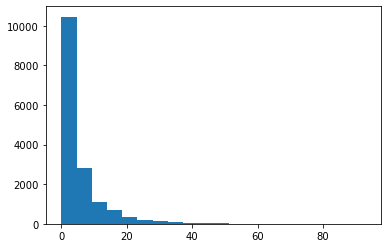

In [31]:
grouped = data_et_choice.groupby(['run_id', 'trial_index']) \
        ['aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL'].sum() \
        .reset_index() 
print(grouped)

data_plot = pd.DataFrame(pd.concat(
    [
        grouped['aoi_aSS'],
        grouped['aoi_tSS'],
        grouped['aoi_aLL'],
        grouped['aoi_tLL']
    ]), columns=['n']) 

plt.hist(data_plot, bins=20)

In [32]:
for var in ['aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL']:
    if var in data_trial_choice.columns: 
        data_trial_choice = data_trial_choice.drop(columns=[var])
        
data_trial_choice = data_trial_choice.merge(
    grouped, 
    on=['run_id', 'trial_index'], 
    how='left')
    
data_trial_choice.loc[
    :, 
    ['run_id', 'trial_index', 'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL']
]

,run_id,trial_index,aoi_aSS,aoi_aLL,aoi_tSS,aoi_tLL
0,1,145.0,0.0,1.0,0.0,1.0
1,1,148.0,0.0,0.0,0.0,0.0
2,1,151.0,0.0,0.0,0.0,0.0
3,1,154.0,0.0,0.0,0.0,0.0
4,1,157.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
4418,2009,495.0,0.0,21.0,0.0,0.0
4419,2009,498.0,0.0,17.0,0.0,0.0
4420,2009,501.0,0.0,15.0,0.0,0.0
4421,2009,504.0,21.0,0.0,0.0,0.0


##  Option Index

In [33]:
def require_min(data, min_required_count):
    return data.replace(
        np.arange(min_required_count), 
        np.repeat(0, min_required_count)) 

def addOptionIndex(data):
    
    gazePoints_immediate = \
        require_min(data['aoi_aSS'], 3) + \
        require_min(data['aoi_tSS'], 3)
    gazePoints_delay = \
        require_min(data['aoi_aLL'], 3) + \
        require_min(data['aoi_tLL'], 3)
    optionIndex = \
        (gazePoints_immediate - gazePoints_delay) / \
        (gazePoints_immediate + gazePoints_delay)
    
    return optionIndex

data_trial_choice['optionIndex'] = addOptionIndex(data_trial_choice)
print(data_trial_choice['optionIndex'].describe())
print(
    pd.DataFrame(
        [
            [sum(pd.isna(data_trial_choice['optionIndex']))],
            [sum(data_trial_choice['optionIndex']==1)],
            [sum(data_trial_choice['optionIndex']==0)],
            [sum((data_trial_choice['optionIndex']>0) &
                 (data_trial_choice['optionIndex']<1))],
            [len(data_trial_choice)]
        ], index = ['NAN', '1', '0', '0>optionIndex>1', 'total']    
    )
)

print(data_trial_choice.loc[:, ['run_id', 'trial_index', 
                          'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
                          'optionIndex']])
print(data_trial_choice.loc[
    ~data_trial_choice['optionIndex'].isin([-1, 1]) &
    pd.notna(data_trial_choice['optionIndex']), 
    ['run_id', 'trial_index', 
     'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
     'optionIndex']])

count    3334.000000
mean       -0.050146
std         0.771749
min        -1.000000
25%        -1.000000
50%        -0.100000
75%         0.798718
max         1.000000
Name: optionIndex, dtype: float64
                    0
NAN              1089
1                 826
0                  73
0>optionIndex>1   663
total            4423
      run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL  optionIndex
0          1        145.0      0.0      1.0      0.0      1.0          NaN
1          1        148.0      0.0      0.0      0.0      0.0          NaN
2          1        151.0      0.0      0.0      0.0      0.0          NaN
3          1        154.0      0.0      0.0      0.0      0.0          NaN
4          1        157.0      0.0      0.0      0.0      0.0          NaN
...      ...          ...      ...      ...      ...      ...          ...
4418    2009        495.0      0.0     21.0      0.0      0.0         -1.0
4419    2009        498.0      0.0     17.0      0.0      0.0     

## Attribute Index

In [34]:
def addAttributeIndex(data):

    gazePoints_amount = \
        require_min(data['aoi_aLL'], 3) + \
        require_min(data['aoi_aSS'], 3)
    gazePoints_time = \
        require_min(data['aoi_tLL'], 3) + \
        require_min(data['aoi_tSS'], 3)

    attributeIndex = \
        (gazePoints_amount - gazePoints_time) / \
        (gazePoints_amount + gazePoints_time)
    
    return attributeIndex


data_trial_choice['attributeIndex'] = addAttributeIndex(data_trial_choice)

print(data_trial_choice['attributeIndex'].describe())
print(pd.DataFrame(
        [
            [sum(pd.isna(data_trial_choice['attributeIndex']))],
            [sum(data_trial_choice['attributeIndex']==1)],
            [sum(data_trial_choice['attributeIndex']==0)],
            [sum((data_trial_choice['attributeIndex']>0) &
                 (data_trial_choice['attributeIndex']<1))],
            [len(data_trial_choice)]
        ], index = ['NAN', '1', '0', '0>attributeIndex>1', 'total']    
    )
)

print(data_trial_choice.loc[:, ['run_id', 'trial_index', 
                          'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
                          'attributeIndex']])
print(data_trial_choice.loc[
    ~data_trial_choice['attributeIndex'].isin([-1, 1]) &
    pd.notna(data_trial_choice['attributeIndex']), 
    ['run_id', 'trial_index', 
     'aoi_aSS', 'aoi_aLL', 'aoi_tSS', 'aoi_tLL', 
     'attributeIndex']])

count    3334.000000
mean        0.148372
std         0.714349
min        -1.000000
25%        -0.367225
50%         0.151515
75%         1.000000
max         1.000000
Name: attributeIndex, dtype: float64
                       0
NAN                 1089
1                   1003
0                     92
0>attributeIndex>1   910
total               4423
      run_id  trial_index  aoi_aSS  aoi_aLL  aoi_tSS  aoi_tLL  attributeIndex
0          1        145.0      0.0      1.0      0.0      1.0             NaN
1          1        148.0      0.0      0.0      0.0      0.0             NaN
2          1        151.0      0.0      0.0      0.0      0.0             NaN
3          1        154.0      0.0      0.0      0.0      0.0             NaN
4          1        157.0      0.0      0.0      0.0      0.0             NaN
...      ...          ...      ...      ...      ...      ...             ...
4418    2009        495.0      0.0     21.0      0.0      0.0             1.0
4419    2009        4

## Payne Index

### Transitions between AOIs

In [35]:
def et_data_transition_type(data):
    data = data.loc[
        pd.notna(data['aoi']) &
        (data['aoi']!=0), :]
    data['newAOIIndex'] = 0
    data.loc[(data['aoi_aLL']==1), 'newAOIIndex'] = 1
    data.loc[(data['aoi_tLL']==1), 'newAOIIndex'] = 2
    data.loc[(data['aoi_aSS']==1), 'newAOIIndex'] = 4
    data.loc[(data['aoi_tSS']==1), 'newAOIIndex'] = 8
    data.sort_values(by=['run_id', 'withinTaskIndex'])
    # Add a 0 due to the way np.diff works
    data['transition_type'] = np.append([0], np.diff(data['newAOIIndex']))
    data['transition_type'] = abs(data['transition_type']) 

    data.loc[data['t_task']==0, 'transition_type'] = 0

    return data.loc[:, ['run_id', 'trial_index', 't_task', 'transition_type']]

def addTransition_type(data, data_et):
    data_et = et_data_transition_type(data_et)
    data_et.loc[:, 'transition_type'] = data_et.loc[:, 'transition_type']
    
    transition_count = pd.pivot_table(
        data_et.loc[:, ['run_id', 'trial_index', 'transition_type']], 
        index = ['run_id', 'trial_index'],
        columns = ['transition_type'], 
        aggfunc = len,
        fill_value = 0) \
        .reset_index() \
        .rename(columns={
        0: "trans_type_0",
        1: "trans_type_aLLtLL",
        2: "trans_type_tLLaSS",
        3: "trans_type_aLLaSS",
        4: "trans_type_aSStSS",
        6: "trans_type_tLLtSS",
        7: "trans_type_aLLtSS"
    })
    
    transition_columns = ["trans_type_0", "trans_type_aLLtLL", 
            "trans_type_tLLaSS", "trans_type_aLLaSS",
            "trans_type_aSStSS", "trans_type_tLLtSS", 
            "trans_type_aLLtSS"]
    
    for var in transition_columns:
        if var in data: 
            data = data.drop(columns=[var])
        
    data = data.merge(transition_count, on=['run_id', 'trial_index'], how='left') 
    data.loc[:, transition_columns] = data.loc[:, transition_columns] \
        .fillna(0)
    return(data)

data_trial_choice = addTransition_type(data_trial_choice, data_et_choice)
data_trial_choice.loc[
    :, 
    [
        'run_id', 'trial_index',
        'aoi_aLL', 'aoi_aSS', 'aoi_tLL', 'aoi_tSS',
        'trans_type_0', 'trans_type_aLLtLL', 'trans_type_tLLaSS',
        'trans_type_aLLaSS', 'trans_type_aSStSS', 'trans_type_tLLtSS',
        'trans_type_aLLtSS'
    ]
]

<ipython-input-35-9621a8002178>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['newAOIIndex'] = 0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

,run_id,trial_index,aoi_aLL,aoi_aSS,aoi_tLL,aoi_tSS,trans_type_0,trans_type_aLLtLL,trans_type_tLLaSS,trans_type_aLLaSS,trans_type_aSStSS,trans_type_tLLtSS,trans_type_aLLtSS
0,1,145.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,151.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,154.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,157.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4418,2009,495.0,21.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
4419,2009,498.0,17.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0
4420,2009,501.0,15.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0
4421,2009,504.0,0.0,21.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
def addPayneIndex(data):
    
    optionWise_transition = \
        data['trans_type_aLLtLL'] + \
        data['trans_type_aSStSS']
    attributeWise_transition = \
        data['trans_type_aLLaSS'] + \
        data['trans_type_tLLtSS']  
        
    payneIndex = \
        (optionWise_transition - attributeWise_transition) / \
        (optionWise_transition + attributeWise_transition) 
    

    return payneIndex

data_trial_choice['payneIndex'] = addPayneIndex(data_trial_choice)

print(data_trial_choice['payneIndex'].describe())
print(pd.DataFrame(
        [
            [sum(pd.isna(data_trial_choice['payneIndex']))],
            [sum(data_trial_choice['payneIndex']==1)],
            [sum(data_trial_choice['payneIndex']==0)],
            [sum((data_trial_choice['payneIndex']>0) &
                 (data_trial_choice['payneIndex']<1))],
            [len(data_trial_choice)]
        ], index = ['NAN', '1', '0', '0>payneIndex>1', 'total']    
    )
)

data_trial_choice.loc[
    data_trial_choice['fps']>15, 
    ['run_id', 'trial_duration_exact',
     'trans_type_aLLtLL', 'trans_type_aSStSS', 'trans_type_aLLaSS', 'trans_type_tLLtSS',
     'payneIndex'
    ]
]

count    2831.000000
mean        0.045353
std         0.722624
min        -1.000000
25%        -0.500000
50%         0.000000
75%         0.600000
max         1.000000
Name: payneIndex, dtype: float64
                   0
NAN             1592
1                678
0                506
0>payneIndex>1   640
total           4423


,run_id,trial_duration_exact,trans_type_aLLtLL,trans_type_aSStSS,trans_type_aLLaSS,trans_type_tLLtSS,payneIndex
80,103,4929.0,4.0,2.0,3.0,2.0,0.090909
81,103,7106.0,7.0,4.0,3.0,1.0,0.466667
82,103,6489.0,5.0,4.0,3.0,1.0,0.384615
83,103,3878.0,1.0,2.0,1.0,1.0,0.200000
84,103,2967.0,2.0,2.0,2.0,0.0,0.333333
...,...,...,...,...,...,...,...
4339,2013,826.0,0.0,0.0,0.0,0.0,NaN
4340,2013,1222.0,0.0,0.0,0.0,1.0,-1.000000
4341,2013,2001.0,0.0,0.0,0.0,2.0,-1.000000
4342,2013,722.0,0.0,0.0,0.0,0.0,NaN


## Aggregate on subject-level

In [37]:
data_subject = merge_by_subject(data_subject, data_trial_choice, 'attributeIndex')
data_subject = merge_by_subject(data_subject, data_trial_choice, 'optionIndex')
data_subject = merge_by_subject(data_subject, data_trial_choice, 'payneIndex')

# k-value

 - Index: Order: A column that stores the order of questions asked
 - aSS: SIR: Column storing the small immediate rewards by choice set
 - aLL: LDR: Column storing the large delayed rewards by choice set
 - tLL: Delay: Column storing the respecitve delays for LDR’s

In [38]:
data_k = data_trial_choice.loc[
    data_trial_choice['run_id']==11, 
    ['run_id', 'withinTaskIndex', 'aSS', 'aLL', 'tLL']]


http://alexanderfengler.github.io/neuroeconomics/K-Estimation/

According to Chabris and Laibson (2008), 'An agent chooses aLL, if Y / (1 + k*t) - X >= 0  holds true'

# Reaction time on subject-level

In [39]:
grouped = data_trial_choice.groupby(['run_id'])['trial_duration_exact'].mean() \
    .reset_index() \
    .rename(columns={'trial_duration_exact': 'choice_rt'})

if 'choice_rt' in data_subject.columns: data_subject = data_subject.drop(columns=['choice_rt'])
data_subject = data_subject.merge(grouped, on='run_id', how='left')
data_subject['choice_rt'].describe()

count      56.000000
mean     2247.761731
std       815.094663
min       897.900000
25%      1700.618750
50%      2060.656250
75%      2651.572321
max      5557.518987
Name: choice_rt, dtype: float64

# Clusters

In [40]:
data_cluster = data_trial_choice.dropna(
    subset=['trans_type_0',
       'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
       'trans_type_aSStSS', 'trans_type_tLLtSS'] , how='all')

data_cluster.loc[:, [
       'trans_type_0',
       'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
       'trans_type_aSStSS', 'trans_type_tLLtSS']
                     ].isnull().any()

trans_type_0         False
trans_type_aLLtLL    False
trans_type_tLLaSS    False
trans_type_aLLaSS    False
trans_type_aSStSS    False
trans_type_tLLtSS    False
dtype: bool

In [41]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_cluster.loc[
    :, 
    ['trans_type_0',
     'trans_type_aLLtLL', 'trans_type_tLLaSS', 'trans_type_aLLaSS',
     'trans_type_aSStSS', 'trans_type_tLLtSS']
]
                                      )

In [42]:
def clusters(n_clusters):
    kmeans = KMeans(
        init="random",
        n_clusters=n_clusters,
        n_init=10,
        max_iter=300,
        random_state=42
    )
    kmeans.fit(scaled_features)
            
#     https://realpython.com/k-means-clustering-python/
#     print(kmeans.inertia_)
#     print(kmeans.cluster_centers_)
#     print(kmeans.n_iter_)

    return kmeans.labels_

In [43]:
output = []
X = data_cluster[["run_id"]] #, "withinTaskIndex"]]
X_ = sm.add_constant(X)
y = 1-data_cluster[["choseLL"]]  
log_reg = sm.Logit(y, X_).fit() 
output.append([0, log_reg.bic, log_reg.aic])
                  
for n_cluster in range(2, 5):
    data_cluster['cluster' + str(n_cluster)] = clusters(n_cluster)
    X = data_cluster[["run_id", 'cluster' + str(n_cluster)]]
    X_ = sm.add_constant(X)
    y = 1-data_cluster[["choseLL"]]  
    log_reg = sm.Logit(y, X_).fit() 
    output.append([n_cluster, log_reg.bic, log_reg.aic]) 

output = pd.DataFrame(output, columns = ['n_clusters', 'BIC', 'AIC']) \
    .set_index('n_clusters')
output

Optimization terminated successfully.
         Current function value: 0.563114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563110
         Iterations 6


,BIC,AIC
n_clusters,,
0,4998.094992,4985.305845
2,4969.182407,4949.998686
3,5000.666936,4981.483216
4,5006.456219,4987.272498


# Export data

In [44]:
if not os.path.exists('./data_jupyter'):
    os.mkdir('./data_jupyter')

data_et_choice.to_csv("data_jupyter/data_et_choice.csv", index=False, header=True)
data_trial_choice.to_csv("data_jupyter/data_trial_choice.csv", index=False, header=True)
data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

MatLab input

In [45]:
if not os.path.exists('./amasino_dataPrep/data_source'):
    os.mkdir('./amasino_dataPrep/data_source')

data_et_choice.loc[:, 
                       [
                           'run_id', 
                           'withinTaskIndex', 
                           'x', 
                           'y', 
                           't_task'
                       ]
                  ] \
   .to_csv("amasino_dataPrep/data_source/schneegansEtAl_ET.csv", index=False, header=False)

In [46]:
data_trial_choice.loc[:, 
                       [
                           'run_id', 
                           'withinTaskIndex', 
                           'optionIndex', 
                           'attributeIndex', 
                           'payneIndex'
                       ]
                  ] \
    .fillna(0) \
    .to_csv("amasino_dataPrep/intermediateCSVs/ET_indices.csv", index=False, header=False)

In [47]:
# Subject ID, Amount smaller sooner (SS), Amount larger later (LL), Time SS, Time LL, 
# choice, response time, side, response side, condition.
data_trial_choice.loc[:, 
                          [
                              'run_id', 
                              'aSS', 
                              'aLL', 
                              'tSS', 
                              'tLL', 
                              'choseLL', 
                              'trial_duration_exact', 
                              'LL_top',
                              'choseTop'
                          ]
                     ] \
    .to_csv("amasino_dataPrep/data_source/schneegansEtAl_behavior.csv", index=False, header=False)

data_trial_choice.loc[:,
                          [
                              'run_id', 
                              'aSS', 
                              'aLL', 
                              'tSS', 
                              'tLL', 
                              'choseLL', 
                              'trial_duration_exact', 
                              'LL_top',
                              'choseTop'
                          ]
                     ] \
    .to_csv("fitK/fit_k_input.csv", index=False, header=True)

In [48]:
data_subject.loc[:, ['run_id', 'choseLL']] \
    .to_csv("amasino_dataPrep/intermediateCSVs/percLeft.csv", index=False, header=False)

# Feedback

In [49]:
print('Success! Script ran through')

Success! Script ran through
